# ***EX4 - Clinical Trial Classification***

In this exercise, you are given (a part of) a data set from a clinical trial You will need to use 3 types of prediction models and compare between them:

- The first model should be a linear classifier.
- The second one should be an ensemble model.
- The third should be a DL one.

Use the concepts we learn in class: train/validation/test split, grid-search, cross validation etc. Notice, there is no need to implement the models, you can use scikit ones.

jupyter notebook should contain the next sections:
 - Loading the data (clean, transform if needed). 
 - Train the three models. 
 - Comparison between the three: quantitative and qualitative (think what is the evaluation method you use).

Answer the next questions:
- For each model, does the model overfit?
- In the DL model, what's the effect of batch size? In general, and do you see this effect in the current task?

Notice: You need to well explain why you choose the specific algorithms, configurations, or other decisions you made.
In the end, briefly summarize the method and details.

### ***Import Packages***

Lets load all the needed packages for this notebook:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.metrics import geometric_mean_score

### ***Load Data***

Let’s load the data set using Pandas:

In [2]:
df = pd.read_csv("/content/ex4_data.csv")

### ***Quick Look at the Data:***

Let’s take a look at the top five rows:

In [3]:
df.head()

,INTENSIVE,NEWSITEID,RISK10YRS,INCLUSIONFRS,SBP,DBP,N_AGENTS,NOAGENTS,SMOKE_3CAT,ASPIRIN,EGFR,SCREAT,SUB_CKD,RACE_BLACK,AGE,FEMALE,SUB_CVD,SUB_CLINICALCVD,SUB_SUBCLINICALCVD,SUB_SENIOR,RACE4,CHR,GLUR,HDL,TRR,UMALCR,BMI,STATIN,SBPTERTILE,EVENT_PRIMARY
0,Regular,74.0,29.732061,True,145,80,2,False,3,True,67.69,1.11,False,False,60,False,True,True,False,False,WHITE,155,81,36,92,5.80,33.115201,True,3,False
1,Regular,8.0,29.677619,True,138,71,1,False,2,True,60.64,1.17,False,False,75,False,False,False,False,True,WHITE,243,107,61,188,5.45,28.842380,True,2,False
2,Intensive,25.0,17.443819,True,143,92,2,False,2,False,68.44,1.09,False,False,62,False,False,False,False,False,WHITE,180,116,47,125,13.33,33.643060,False,2,False
3,Regular,96.0,8.627849,False,123,68,2,False,1,False,71.94,0.78,False,False,75,True,False,False,False,True,WHITE,234,93,89,109,6.12,29.337871,False,1,False
4,Intensive,42.0,23.751437,True,126,51,2,False,2,False,50.19,1.36,True,False,81,False,False,False,False,True,WHITE,126,108,39,84,28.78,36.660286,False,1,False


We can see that each record contains the following features:

- INTENSIVE (Categorical) - The clinical arm that was used (intensive or regular)
- NEWSITEID (Categorical) - Site ID in which the participant was treated
- RISK10YRS (Numeric) - Predicted risk for cardiovascular diseases
- INCLUSIONFRS (Boolean) - Binary risk group
- SBP (Numeric) - Systolic blood pressure 
- DBP (Numeric) - Diastolic blood pressure
- N_AGENTS (Categorical) - Number of medications prescribed 
- NOAGENTS (Boolean) - Participants on no anti-hypertensive agents
- SMOKE_3CAT (Categorical) - Derived: Baseline smoking status
- ASPIRIN (Boolean) - BSL Hist: Daily Aspirin Use
- EGFR (Numeric) - Lab: eGFR MDRD (mL/min/1.73m^2)
- SCREAT (Numeric) - Lab: serum creatinine, mg/dL
- SUB_CKD (Boolean) - Derived: Subgroup with CKD (eGFR < 60)
- RACE_BLACK (Boolean) - Incl/Excl: Black, African-American
- AGE (Numeric) - Derived: Age at randomization top-coded at 90 years
- FEMALE (Boolean) - Derived: Female gender
- SUB_CVD (Boolean) - Derived: subgroup with history of clinical/subclinical CVD
- SUB_CLINICALCVD (Boolean) - Derived: subgroup with history of clinical CVD
- SUB_SUBCLINICALCVD (Boolean) - Derived: subgroup with history of subclinical CVD
- SUB_SENIOR (Boolean) - Derived: subgroup >= 75 years old at randomization
- RACE4 (Categorical) - Derived: Four-level race variable (character)
- CHR (Numeric) - Lab: Cholesterol, mg/dL
- GLUR (Numeric) - Lab: Glucose, mg/dL
- HDL (Numeric) - Lab: HDL-cholesterol direct, mg/dL
- TRR (Numeric) - Lab: Triglycerides, mg/dL
- UMALCR (Numeric) - Lab: mg Urine Alb / (g Creat * 0.01), mg/g Cr
- BMI (Numeric) - Derived: body mass index (kg/m^2)
- STATIN (Boolean) - Derived: on any statin
- SBPTERTILE (Categorical) - Derived: Systolic BP tertile
- EVENT_PRIMARY (Boolean) - Outcome (patient died or had a cardiovascular event)

### ***Feature Analysis***

Let's gather some information about different columns in the dataset:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8746 entries, 0 to 8745
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   INTENSIVE           8746 non-null   object 
 1   NEWSITEID           8281 non-null   float64
 2   RISK10YRS           8746 non-null   float64
 3   INCLUSIONFRS        8746 non-null   bool   
 4   SBP                 8746 non-null   int64  
 5   DBP                 8746 non-null   int64  
 6   N_AGENTS            8746 non-null   int64  
 7   NOAGENTS            8746 non-null   bool   
 8   SMOKE_3CAT          8746 non-null   int64  
 9   ASPIRIN             8746 non-null   bool   
 10  EGFR                8746 non-null   float64
 11  SCREAT              8746 non-null   float64
 12  SUB_CKD             8746 non-null   bool   
 13  RACE_BLACK          8746 non-null   bool   
 14  AGE                 8746 non-null   int64  
 15  FEMALE              8746 non-null   bool   
 16  SUB_CV

We can see the following information:
- There are 8746 records.
- NEWSITEID column has 465 out of 8746 missing values (0.05%). 

Let's get some basic statistical details:

In [5]:
df.describe()

,NEWSITEID,RISK10YRS,SBP,DBP,N_AGENTS,SMOKE_3CAT,EGFR,SCREAT,AGE,CHR,GLUR,HDL,TRR,UMALCR,BMI,SBPTERTILE
count,8281.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000,8746.000000
mean,55.820674,20.143798,139.704894,78.149325,1.837754,1.695632,71.689646,1.077442,67.893666,189.993025,98.907729,52.787674,126.092271,42.528651,29.882733,2.006403
std,29.743937,10.843465,15.623359,11.988268,1.035492,0.693989,20.684404,0.342435,9.432551,41.112715,13.614090,14.523649,84.036103,166.747879,5.786064,0.821080
min,1.000000,1.863811,72.000000,40.000000,0.000000,1.000000,14.660000,0.420000,50.000000,71.000000,44.000000,17.000000,23.000000,1.360000,13.734281,1.000000
25%,32.000000,12.051891,130.000000,70.000000,1.000000,1.000000,57.980000,0.860000,61.000000,161.000000,91.000000,43.000000,77.000000,5.630000,25.915815,1.000000
50%,58.000000,17.821904,138.000000,78.000000,2.000000,2.000000,71.310000,1.010000,67.000000,186.000000,97.000000,50.000000,107.000000,9.520000,29.041334,2.000000
75%,81.000000,25.762838,149.000000,86.000000,3.000000,2.000000,84.720000,1.210000,76.000000,214.000000,105.000000,60.000000,150.000000,21.430000,32.937432,3.000000
max,102.000000,81.187680,231.000000,134.000000,6.000000,3.000000,186.190000,4.040000,90.000000,437.000000,286.000000,161.000000,2414.000000,5000.000000,69.591365,3.000000


Let's create list for each type of column:

In [6]:
# define Categorical columns
categorical_columns = ["INTENSIVE", "NEWSITEID", "N_AGENTS", 
                       "SMOKE_3CAT", "RACE4", "SBPTERTILE"]
# define numeric columns
numeric_columns = ["RISK10YRS", "SBP", "DBP", "EGFR", "SCREAT",
                   "AGE", "CHR", "GLUR", "HDL", "TRR", "UMALCR", "BMI"]
# define bool columns
bool_columns = ["INCLUSIONFRS", "NOAGENTS", "ASPIRIN", "SUB_CKD", 
                "RACE_BLACK", "FEMALE", "SUB_CVD", "SUB_CLINICALCVD",
                "SUB_SUBCLINICALCVD", "SUB_SENIOR", "STATIN"]

### ***EDA***

Let's plot the categorical columns:

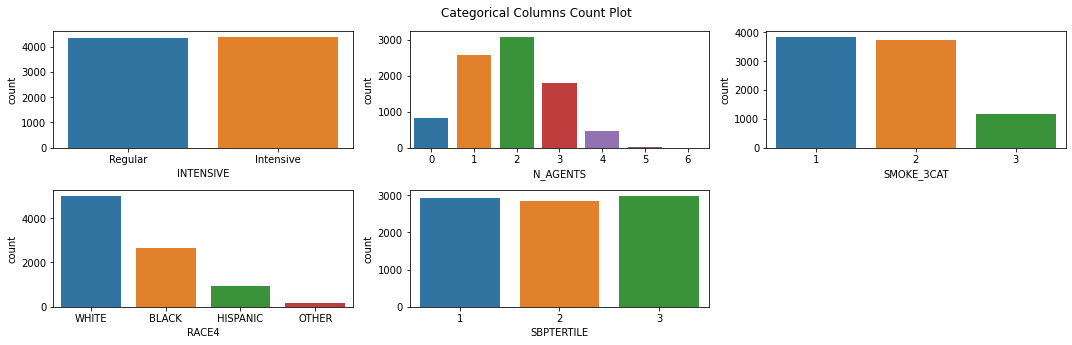

In [32]:
# copy categorical columns to remove NEWSITEID
cols = categorical_columns.copy() 
cols.remove('NEWSITEID')

# create sub plot for each categorical column
fig, axs = plt.subplots(2,3, figsize=(15,5))
fig.delaxes(axs[1, -1])

# loop over each subplot categorical column
for col, ax in zip(cols, axs.flatten()):
    # plot countplot
    sns.countplot(x=col, data=df, ax=ax)

# show plot
fig.suptitle("Categorical Columns Count Plot")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Let's plot the boolean columns:

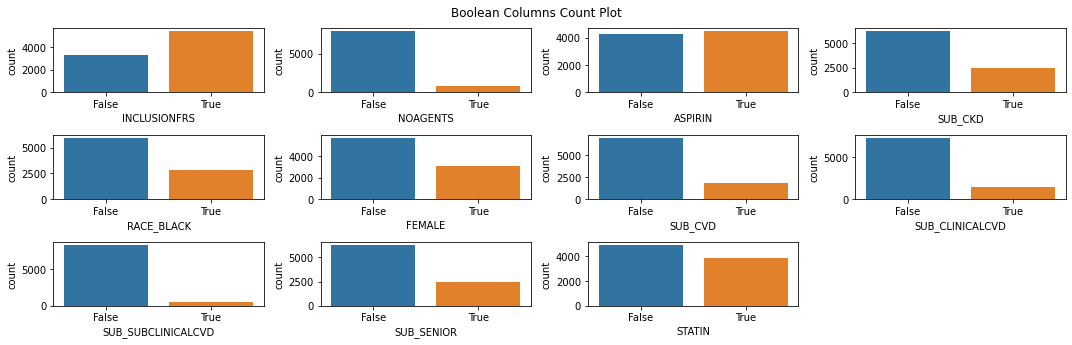

In [33]:
# copy bool columns
cols = bool_columns.copy() 

# create sub plot for each bool column
fig, axs = plt.subplots(3, 4, figsize=(15,5))
fig.delaxes(axs[2, -1])

# loop over each subplot bool column
for col, ax in zip(cols, axs.flatten()):
    # plot countplot
    sns.countplot(x=col, data=df, ax=ax)

# show plot
fig.suptitle("Boolean Columns Count Plot")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Let's plot the numeric columns:

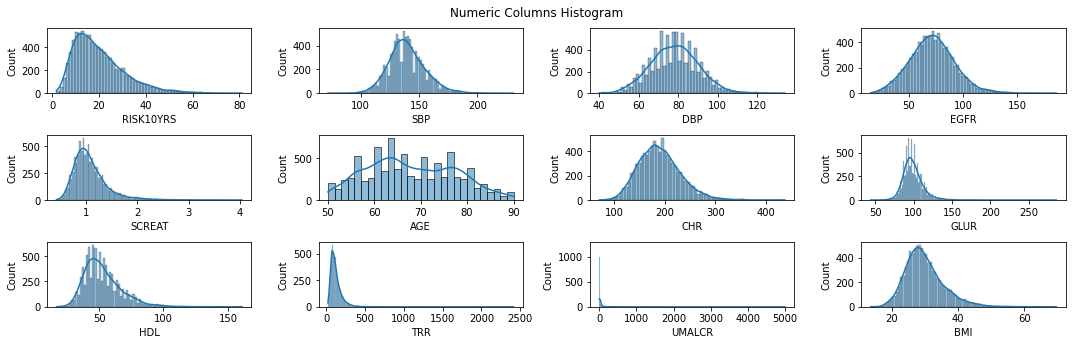

In [34]:
# copy numeric columns
cols = numeric_columns.copy() 

# create sub plot for each numeric column
fig, axs = plt.subplots(3, 4, figsize=(15,5))

# loop over each subplot numeric column
for col, ax in zip(cols, axs.flatten()):
    # plot countplot
    sns.histplot(x=col, data=df, ax=ax, kde=True)

# show plot
fig.suptitle("Numeric Columns Histogram")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Lastly let's plot the target plot:

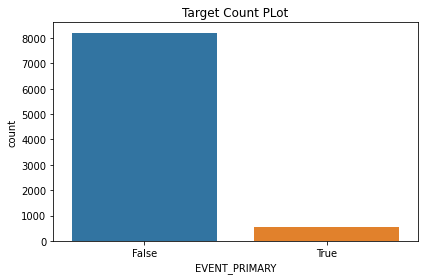

In [10]:
# plot countplot
sns.countplot(x='EVENT_PRIMARY', data=df)

# show plot
plt.title("Target Count PLot")
plt.tight_layout()
plt.show()

From these plots we can get a lot of information:
1. Some numeric columns are skewed so scaling is needed.
2. Target is imbalanced so accuracy as a metric will not be good (majority rule will get good accuracy). Also we need to find a way to deal with this imbalance.

### ***Pre Process***

Let's create features and target sets:

In [11]:
# create target set
y = df["EVENT_PRIMARY"].astype('int')
# create features set
X = df.drop(["EVENT_PRIMARY"], axis=1)

Let's split data to train and test set:

In [12]:
# split data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

Let's create transformers to preprocess columns:

In [13]:
# create transformer for boolean column
# missing data filled with most frequent value
# true value turn to 1 and false to 0
boolean_transformer = Pipeline(
    steps=[("int", FunctionTransformer(np.int64))]
)

# create transformer for numeric columns
# missing data filled median value of column
# standard scaling is applied
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

# create transformer for categorical columns
# missing data filled with most frequent value
# one hot encoding applied to each column
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("ohe", OneHotEncoder(handle_unknown = "ignore"))]
)

# combine transformers to apply on corresponding columns
preprocessor = ColumnTransformer(
    transformers=[
        ("bool", boolean_transformer, bool_columns),
        ("num", numeric_transformer, numeric_columns),
        ("cat", categorical_transformer, categorical_columns),
    ]
)

Let's preprocess our data:

In [14]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

### ***Deal with Imbalance Data Using Resample***

Let's resample using smote algorithm:

In [15]:
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

Let's create a metric for imbalance data (geometric mean score):

In [16]:
gm_scorer = make_scorer(geometric_mean_score, greater_is_better=True,
                        average='binary')

### ***Model 1 - Logistic Regression Classifier***

The first model we will train is a logistic regression classifier:

In [17]:
# define model 
lr = LogisticRegression(random_state=0)

# define grid search parameters
param_grid = {
    "C": np.logspace(-4, 4, 4),
    "max_iter": [300],
    "penalty": ["l1", "l2"],
    "solver" : ["liblinear"]
}

# create grid search
lr_search = GridSearchCV(lr, param_grid,
                      cv=StratifiedKFold(n_splits=5), 
                      scoring=gm_scorer,
                      verbose = 3
)

# fit grid search
lr_search.fit(X_train, y_train)

# print best score and parameters
print(f"Best parameters ({lr_search.best_score_}):")
print(lr_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END C=0.0001, max_iter=300, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 2/5] END C=0.0001, max_iter=300, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 3/5] END C=0.0001, max_iter=300, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 4/5] END C=0.0001, max_iter=300, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 5/5] END C=0.0001, max_iter=300, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 1/5] END C=0.0001, max_iter=300, penalty=l2, solver=liblinear;, score=0.640 total time=   0.0s
[CV 2/5] END C=0.0001, max_iter=300, penalty=l2, solver=liblinear;, score=0.631 total time=   0.0s
[CV 3/5] END C=0.0001, max_iter=300, penalty=l2, solver=liblinear;, score=0.618 total time=   0.0s
[CV 4/5] END C=0.0001, max_iter=300, penalty=l2, solver=liblinear;, score=0.640 total time=   0.0s
[CV 5/5] END C=0.0001, max_iter=300, penalty=l2, 

Let's get the test score:

In [18]:
# predict on test set
y_pred = lr_search.best_estimator_.predict(X_test)

# print results
print(f"Test score: {geometric_mean_score(y_pred, y_test)}")

Test score: 0.2821829665539517


Lastly, let's plot the confusion matrix:

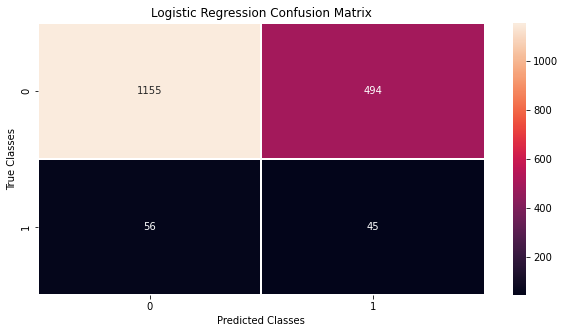

In [19]:
# plot confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, y_pred), linewidths=1, annot=True,
            fmt='g')
plt.title("Logistic Regression Confusion Matrix")
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.show()

### ***Model 2 - AdaBoost Classifier***

The second model we will train is a ada boost classifier:

In [20]:
# define model 
ensemble = AdaBoostClassifier(random_state=0)

# define grid search parameters
param_grid = {
    "n_estimators": [50, 100, 150, 200],
}

# create grid search
ensemble_search = GridSearchCV(ensemble, param_grid,
                      cv=StratifiedKFold(n_splits=5), 
                      scoring=gm_scorer,
                      verbose=3
)

# fit grid search
ensemble_search.fit(X_train, y_train)

# print best score and parameters
print(f"Best parameters ({ensemble_search.best_score_}):")
print(ensemble_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...................n_estimators=50;, score=0.790 total time=   1.6s
[CV 2/5] END ...................n_estimators=50;, score=0.932 total time=   1.5s
[CV 3/5] END ...................n_estimators=50;, score=0.946 total time=   1.5s
[CV 4/5] END ...................n_estimators=50;, score=0.951 total time=   1.5s
[CV 5/5] END ...................n_estimators=50;, score=0.944 total time=   1.5s
[CV 1/5] END ..................n_estimators=100;, score=0.797 total time=   3.1s
[CV 2/5] END ..................n_estimators=100;, score=0.963 total time=   3.0s
[CV 3/5] END ..................n_estimators=100;, score=0.974 total time=   3.0s
[CV 4/5] END ..................n_estimators=100;, score=0.970 total time=   3.0s
[CV 5/5] END ..................n_estimators=100;, score=0.966 total time=   3.1s
[CV 1/5] END ..................n_estimators=150;, score=0.805 total time=   4.7s
[CV 2/5] END ..................n_estimators=150;,

Let's get the test score:

In [21]:
# predict on test set
y_pred = ensemble_search.best_estimator_.predict(X_test)

# print results
print(f"Test score: {geometric_mean_score(y_pred, y_test)}")

Test score: 0.31234204768113494


Lastly, let's plot the confusion matrix:

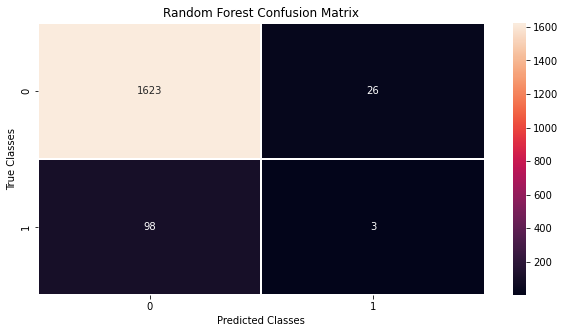

In [22]:
# plot confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, y_pred), linewidths=1, annot=True,
            fmt='g')
plt.title("Random Forest Confusion Matrix")
plt.ylabel("True Classes")
plt.xlabel("Predicted Classes")
plt.show()

### ***Model 3 - Multi-layer Perceptron Classifier***

The third model we will train is a multi-layer perceptron classifier:

In [23]:
# define model 
dl = MLPClassifier(random_state=0)

# define grid search parameters
param_grid = {
    "batch_size": [16, 32, 64, 512],
    "max_iter" : [300]
}

# create grid search
dl_search = GridSearchCV(dl, param_grid,
                      cv=StratifiedKFold(n_splits=5), 
                      scoring=gm_scorer,
                      verbose=3
)

# fit grid search
dl_search.fit(X_train, y_train)

# print best score and parameters
print(f"Best parameters ({dl_search.best_score_}):")
print(dl_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .......batch_size=16, max_iter=300;, score=0.975 total time=  46.2s
[CV 2/5] END .......batch_size=16, max_iter=300;, score=0.974 total time=  50.4s
[CV 3/5] END .......batch_size=16, max_iter=300;, score=0.975 total time=  51.5s
[CV 4/5] END .......batch_size=16, max_iter=300;, score=0.975 total time= 1.2min
[CV 5/5] END .......batch_size=16, max_iter=300;, score=0.975 total time=  59.5s
[CV 1/5] END .......batch_size=32, max_iter=300;, score=0.979 total time=  35.0s
[CV 2/5] END .......batch_size=32, max_iter=300;, score=0.977 total time=  32.1s
[CV 3/5] END .......batch_size=32, max_iter=300;, score=0.973 total time=  34.9s
[CV 4/5] END .......batch_size=32, max_iter=300;, score=0.975 total time=  36.4s
[CV 5/5] END .......batch_size=32, max_iter=300;, score=0.973 total time=  33.4s
[CV 1/5] END .......batch_size=64, max_iter=300;, score=0.977 total time=  23.5s
[CV 2/5] END .......batch_size=64, max_iter=300;,

Let's get the test score:

In [24]:
# predict on test set
y_pred = dl_search.best_estimator_.predict(X_test)

# print results
print(f"Test score: {geometric_mean_score(y_pred, y_test)}")

Test score: 0.33349227795017017


Lastly, let's plot the confusion matrix:

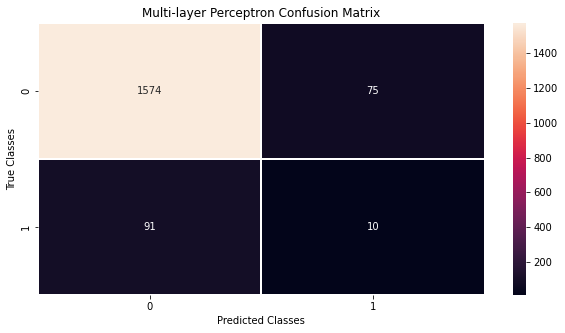

In [25]:
# plot confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, y_pred), linewidths=1, annot=True,
            fmt='g')
plt.title("Multi-layer Perceptron Confusion Matrix")
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.show()

### ***Summarization and Answers to Questions***

***Method and details:***

- We use the logistic regression, ada boost and multilayer perceptron.
- Each model has its best parameters using grid search.
- Evaluation was done using a geometric mean score.

***Comparison of the models:***

- Logistic regression and Ada boost  have the lowest geometric mean score but we can see that logistic regression is able to predict pretty well on the minority class and random forest is not.
- Multi layer perceptron has the biggest geometric mean score and also we can see it is not able to predict the minority class that well but better than random forest.

***Question: For each model, does the model overfit?***

Answer:

Yes we can see all the models overfit to the majority class causing test scores to be low and training scores to be high.

***Question: In the DL model, what's the effect of batch size? In general, and do you see this effect in the current task?***

Answer:
Batch size is one of the important hyperparameters to tune. larger batch size allows computational speedups. However, it is well known that too large of a batch size will lead to poor generalization. On the other hand, using smaller batch sizes have been empirically shown to have faster convergence to good solutions as it allows the model to start learning before having seen all the data. But the downside could be that the model is not guaranteed to converge to the global optima.

For this task we can see that large batch sizes (64,512) take less time to execute and do not generalize that well but also small batch (16,32) sizes do not generalize that well, probably because of the data.